EMG Signal Processing Pipeline - Real Data Analysis

This notebook analyzes real EMG data from RawEMG.csv (single-channel BICEP recording)

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, spectrogram

## Load Real EMG Data (RawEMG.csv)

In [65]:
# Load the real EMG data
df = pd.read_csv('RawEMG.csv')

print(f"Data shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

# Extract EMG signal (BICEP channel)
emg_signal = df['BICEP'].values

# Parse timestamps to calculate sampling rate
# Convert timestamp strings to seconds
def parse_timestamp(ts_str):
    """Convert timestamp string 'HH:MM:SS.ms' to seconds"""
    parts = ts_str.split(':')
    hours = float(parts[0])
    minutes = float(parts[1])
    seconds = float(parts[2])
    return hours * 3600 + minutes * 60 + seconds

timestamps_seconds = df['Timestamp'].apply(parse_timestamp).values

# Calculate sampling rate
duration = timestamps_seconds[-1] - timestamps_seconds[0]
n_samples = len(emg_signal)
fs = n_samples / duration

# Create uniform time array
timestamps = np.linspace(0, duration, n_samples)

print(f"\nData characteristics:")
print(f"  Duration: {duration:.2f} seconds")
print(f"  Number of samples: {n_samples}")
print(f"  Sampling rate: {fs:.1f} Hz")
print(f"  EMG signal range: {emg_signal.min():.6f} to {emg_signal.max():.6f} V")
print(f"  EMG signal mean: {emg_signal.mean():.6f} V")
print(f"  EMG signal std: {emg_signal.std():.6f} V")

# Parameters
n_channels = 1  # Single channel data

Data shape: (60307, 4)
Columns: ['Timestamp', 'BICEP', 'BioRadio Event', 'Unnamed: 3']

First few rows:
       Timestamp     BICEP  BioRadio Event  Unnamed: 3
0       00:00:00  0.004377               0         NaN
1  00:00:00.0005  0.004377               0         NaN
2   00:00:00.001  0.004377               0         NaN
3  00:00:00.0015  0.004377               0         NaN
4   00:00:00.002  0.004377               0         NaN

Data characteristics:
  Duration: 30.15 seconds
  Number of samples: 60307
  Sampling rate: 2000.0 Hz
  EMG signal range: 0.002764 to 0.006683 V
  EMG signal mean: 0.004323 V
  EMG signal std: 0.000273 V


## Visualize Raw EMG Signal

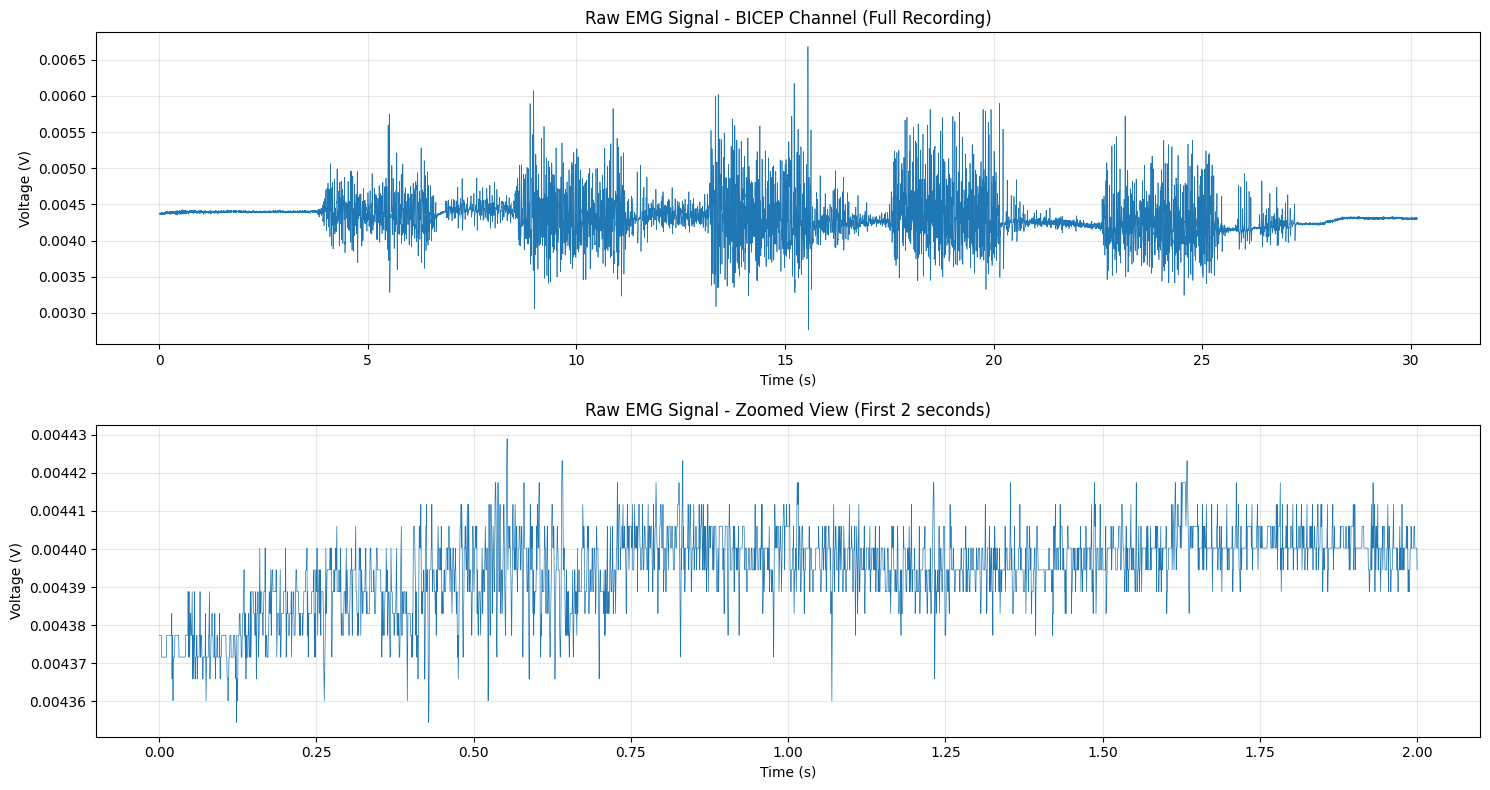

In [66]:
# Plot raw EMG signal
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Full signal
axes[0].plot(timestamps, emg_signal, linewidth=0.5)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Voltage (V)')
axes[0].set_title('Raw EMG Signal - BICEP Channel (Full Recording)')
axes[0].grid(True, alpha=0.3)

# Zoomed view (first 2 seconds)
zoom_end = min(2.0, duration)
zoom_mask = timestamps <= zoom_end
axes[1].plot(timestamps[zoom_mask], emg_signal[zoom_mask], linewidth=0.5)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Voltage (V)')
axes[1].set_title('Raw EMG Signal - Zoomed View (First 2 seconds)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Configuration Parameters

Set all adjustable parameters for signal processing in one place

In [67]:
# ==================== FILTER PARAMETERS ====================
# Bandpass filter
BANDPASS_LOW = 20      # Hz - lower cutoff frequency
BANDPASS_HIGH = 450    # Hz - upper cutoff frequency
BANDPASS_ORDER = 4     # Filter order

# Notch filter
NOTCH_FREQ = 60        # Hz - frequency to remove (powerline interference)
NOTCH_QUALITY = 30     # Quality factor

# Envelope filter
ENVELOPE_CUTOFF = 5.0  # Hz - low-pass filter cutoff for envelope extraction

# ==================== FEATURE EXTRACTION PARAMETERS ====================
# RMS/MAV window size
WINDOW_SIZE_MS = 200   # milliseconds - time window for RMS/MAV calculation

# ==================== CONTRACTION DETECTION PARAMETERS ====================
# Rate-of-change detection method
RATE_THRESHOLD = 0.0005       # V/s - threshold for detecting contraction onset/offset
MIN_CONTRACTION_DURATION = 0.1  # seconds - minimum duration for valid contraction

# Threshold-based detection (fallback method)
BASELINE_SAMPLES_PERCENT = 0.1  # Use first 10% of data as baseline
THRESHOLD_FACTOR = 1.5         # Multiplier for baseline std

# ==================== FATIGUE ANALYSIS PARAMETERS ====================
RMS_FATIGUE_THRESHOLD = 3.0    # Sensitivity for RMS rate of change (31.7% increase during fatigue)
MF_FATIGUE_THRESHOLD = -0.5    # Hz/sec decline threshold for median frequency (-0.89 Hz/sec during fatigue)

print("✓ Configuration parameters loaded")
print(f"  Bandpass: {BANDPASS_LOW}-{BANDPASS_HIGH} Hz")
print(f"  Notch: {NOTCH_FREQ} Hz")
print(f"  RMS window: {WINDOW_SIZE_MS} ms")
print(f"  Contraction rate threshold: {RATE_THRESHOLD} V/s")

✓ Configuration parameters loaded
  Bandpass: 20-450 Hz
  Notch: 60 Hz
  RMS window: 200 ms
  Contraction rate threshold: 0.0005 V/s


## Define All Processing Functions

In [68]:
# ==================== FILTER FUNCTIONS ====================

def butter_bandpass(data, low, high, fs, order=4):
    """Apply Butterworth bandpass filter"""
    nyquist = fs / 2  # Nyquist frequency
    b, a = butter(order, [low/nyquist, high/nyquist], btype="band")
    return filtfilt(b, a, data)

def notch(data, freq, fs, quality=30):
    """Apply notch filter to remove specific frequency (e.g., 60 Hz powerline)"""
    nyquist = fs / 2
    bandwidth = freq / quality
    b, a = butter(2, [(freq-bandwidth/2)/nyquist, (freq+bandwidth/2)/nyquist], btype="bandstop")
    return filtfilt(b, a, data)

def rectify(data):
    """Full-wave rectification"""
    return abs(data)

def envelope(data, fs, cutoff=5.0):
    """Extract envelope using rectification + low-pass filter"""
    nyquist = fs / 2
    b, a = butter(4, cutoff/nyquist, btype="low")
    return filtfilt(b, a, abs(data))

# ==================== FEATURE FUNCTIONS ====================

def rms(data):
    """Calculate Root Mean Square"""
    return np.sqrt(np.mean(data**2, axis=1, keepdims=True))

def mav(data):
    """Calculate Mean Absolute Value"""
    return np.mean(np.abs(data), axis=1, keepdims=True)

def averaged_channels(data):
    """Average across all channels"""
    return np.mean(data, axis=0, keepdims=True).T

def first_contraction_indices(rms_data, baseline_samples=200, threshold_factor=2):
    """
    Find the start and end indices of the first contraction in an RMS array.

    Parameters:
    - rms_data: numpy array of RMS values
    - baseline_samples: number of initial samples to compute baseline
    - threshold_factor: multiplier of baseline std to set threshold

    Returns:
    - start_idx, end_idx: indices of the first contraction (None, None if none found)
    """
    # Compute baseline RMS from first few samples
    baseline_mean = np.mean(rms_data[:baseline_samples])
    baseline_std = np.std(rms_data[:baseline_samples])
    
    # Set threshold
    threshold = baseline_mean + threshold_factor * baseline_std
    
    # Boolean mask for above-threshold
    above_thresh = rms_data > threshold
    
    # Find first contraction
    in_contraction = False
    start_idx, end_idx = None, None
    for i, val in enumerate(above_thresh):
        if val and not in_contraction:
            start_idx = i
            in_contraction = True
        elif not val and in_contraction:
            end_idx = i
            break  # only want the first contraction
    
    # Handle case if contraction goes till the end
    if in_contraction and end_idx is None:
        end_idx = len(rms_data) - 1
    
    return start_idx, end_idx

def calculate_baseline(data):
    """Calculate baseline from pre-contraction period"""
    start_i, end_i = first_contraction_indices(data, baseline_samples=3, threshold_factor=1.5)
    baseline = np.mean(data[start_i:end_i]) if start_i is not None and end_i is not None else np.mean(data[:200])
    return baseline

def detect_contractions_rms_rate(rms_data, fs, rate_threshold=0.001, min_duration_samples=5):
    """
    Detect muscle contractions based on rate of change in RMS.
    
    Parameters:
    - rms_data: numpy array of RMS values
    - fs: effective sampling frequency of the RMS data (e.g., fs/window_size)
    - rate_threshold: threshold for rate of change (V/s) to detect contraction onset
    - min_duration_samples: minimum number of samples for a valid contraction
    
    Returns:
    - contractions: list of tuples (start_time, end_time, peak_rms) for each detected contraction
    """
    # Calculate rate of change of RMS
    drms_dt = np.gradient(rms_data, 1/fs)
    
    # Detect onset points (positive rate of change above threshold)
    onset_mask = drms_dt > rate_threshold
    
    # Detect offset points (negative rate of change below negative threshold)
    offset_mask = drms_dt < -rate_threshold
    
    # Find contraction periods
    contractions = []
    in_contraction = False
    start_idx = None
    
    for i in range(len(rms_data)):
        if onset_mask[i] and not in_contraction:
            # Contraction onset detected
            start_idx = i
            in_contraction = True
        elif offset_mask[i] and in_contraction:
            # Contraction offset detected
            end_idx = i
            duration = end_idx - start_idx
            
            # Only include if duration meets minimum requirement
            if duration >= min_duration_samples:
                start_time = start_idx / fs
                end_time = end_idx / fs
                peak_rms = np.max(rms_data[start_idx:end_idx])
                contractions.append((start_time, end_time, peak_rms))
            
            in_contraction = False
            start_idx = None
    
    # Handle case where contraction extends to end of signal
    if in_contraction and start_idx is not None:
        duration = len(rms_data) - start_idx
        if duration >= min_duration_samples:
            start_time = start_idx / fs
            end_time = (len(rms_data) - 1) / fs
            peak_rms = np.max(rms_data[start_idx:])
            contractions.append((start_time, end_time, peak_rms))
    
    return contractions

def activation_timing_post(rms_data, fs, baseline_threshold):
    """Return time points where RMS exceeds baseline threshold"""
    rms_arr = np.ravel(np.asarray(rms_data))
    t_rms = np.arange(len(rms_arr)) / fs
    mask = rms_arr > baseline_threshold
    return t_rms[mask]

def time_to_fatigue_post(rec_data, notch_data, fs, rms_threshold, mf_threshold):
    """
    Calculate time to fatigue based on RMS and median frequency.
    
    Monitor changes in RMS (increases as fatigue progresses due to increased motor unit recruitment ~20-30%)
    and median frequency (MF) (decreases as fatigue progresses due to slowing of muscle fiber conduction velocity).
    
    Parameters:
    - rec_data: rectified/filtered EMG signal
    - notch_data: notch-filtered EMG signal for frequency analysis
    - fs: sampling frequency
    - rms_threshold: sensitivity for RMS rate of change (31.7% increase in non-athletes during fatigue)
    - mf_threshold: Hz/sec decline threshold for median frequency (-0.89 Hz/sec decline during fatigue)
    
    Returns:
    - time_to_rms_fatigue: time array of RMS fatigue onset points (or None)
    - time_to_mf_fatigue: time array of MF fatigue onset points (or None)
    """
    # RMS array calculation
    window_size = 200
    rms_data = np.sqrt(np.convolve(rec_data**2, np.ones(window_size)/window_size, mode='valid'))
    t_rms = np.arange(len(rms_data)) / fs  # time vector for rms
    
    # Determine baseline contraction rms
    baseline_rms = calculate_baseline(rms_data)
    
    # RMS rate of change
    rms_threshold_value = baseline_rms * 1/rms_threshold
    drms = np.gradient(rms_data, 1/fs) 
    rms_indices = np.where(drms > rms_threshold_value)
    
    # Handle empty array case
    if len(rms_indices[0]) > 0:
        time_to_rms_fatigue = t_rms[rms_indices[0]]  # First occurrence
    else:
        time_to_rms_fatigue = None

    # Median frequency calculation with improved implementation
    nperseg = 256
    noverlap = nperseg - 50  # Using overlap for cleaner implementation
    
    f, t_spec, Sxx = spectrogram(notch_data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    
    # Calculate median frequency for each time window
    median_freqs = []
    for i in range(Sxx.shape[1]):
        psd = Sxx[:, i]
        cumsum = np.cumsum(psd)
        cumsum /= cumsum[-1]  # normalize
        mf = np.interp(0.5, cumsum, f)
        median_freqs.append(mf)
    
    median_freqs = np.array(median_freqs)
    times = t_spec

    # Rate of change of median frequency
    dmf = np.gradient(median_freqs, np.mean(np.diff(times)))
    mf_indices = np.where(dmf < mf_threshold)

    # Handle empty array case
    if len(mf_indices[0]) > 0:
        time_to_mf_fatigue = times[mf_indices[0]]  # First occurrence
    else:
        time_to_mf_fatigue = None

    return time_to_rms_fatigue, time_to_mf_fatigue

# ==================== TRANSFORM FUNCTIONS ====================

def fft_transform(data):
    """Apply FFT transform"""
    return np.abs(np.fft.rfft(data, axis=1))

# ==================== PROCESSING PIPELINES ====================

def process_filtered(data, fs):
    """Apply bandpass filter + notch filter (uses config parameters)"""
    bandpassed = butter_bandpass(data, low=BANDPASS_LOW, high=BANDPASS_HIGH, fs=fs, order=BANDPASS_ORDER)
    filtered = notch(bandpassed, freq=NOTCH_FREQ, fs=fs, quality=NOTCH_QUALITY)
    return filtered

def process_rectified(data):
    """Apply full-wave rectification"""
    return rectify(data)

def process_envelope(data, fs):
    """Apply envelope detection (rectify + low-pass filter)"""
    return envelope(data, fs=fs, cutoff=ENVELOPE_CUTOFF)

def process_fft(data):
    """Apply FFT transform"""
    if data.ndim == 1:
        data = data.reshape(1, -1)
    return fft_transform(data)

print("✓ All processing functions defined (CORRECTED FILTER NORMALIZATION):")
print("  Filters: butter_bandpass, notch, rectify, envelope")
print("  Features: rms, mav, averaged_channels, calculate_baseline, detect_contractions_rms_rate, activation_timing_post, time_to_fatigue_post")
print("  Transforms: fft_transform")
print("  Pipelines: process_filtered, process_rectified, process_envelope, process_fft")

✓ All processing functions defined (CORRECTED FILTER NORMALIZATION):
  Filters: butter_bandpass, notch, rectify, envelope
  Features: rms, mav, averaged_channels, calculate_baseline, detect_contractions_rms_rate, activation_timing_post, time_to_fatigue_post
  Transforms: fft_transform
  Pipelines: process_filtered, process_rectified, process_envelope, process_fft


## Apply Filtering Pipeline

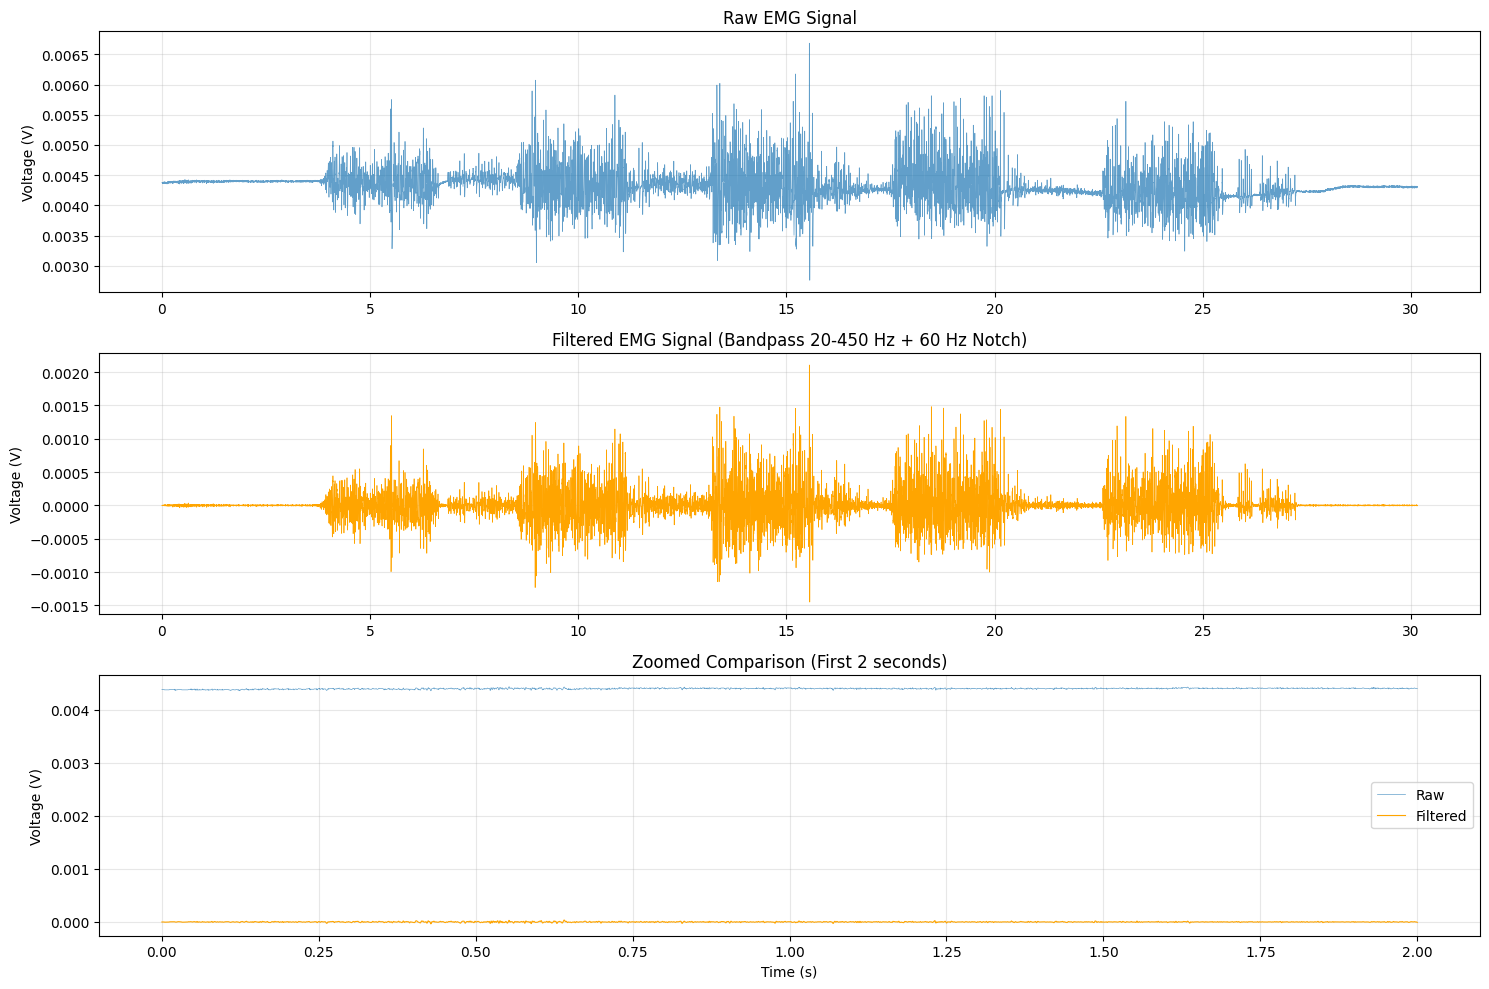

Raw signal: min=0.002764 V, max=0.006683 V, std=0.000273 V
Filtered signal: min=-0.001451 V, max=0.002107 V, std=0.000234 V


In [69]:
# Apply filtered processing
raw_signal = emg_signal
filtered_signal = process_filtered(raw_signal, fs)

# Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Raw signal
axes[0].plot(timestamps, raw_signal, linewidth=0.5, alpha=0.7)
axes[0].set_ylabel('Voltage (V)')
axes[0].set_title('Raw EMG Signal')
axes[0].grid(True, alpha=0.3)

# Filtered signal
axes[1].plot(timestamps, filtered_signal, linewidth=0.5, color='orange')
axes[1].set_ylabel('Voltage (V)')
axes[1].set_title(f'Filtered EMG Signal (Bandpass 20-450 Hz + 60 Hz Notch)')
axes[1].grid(True, alpha=0.3)

# Zoomed comparison (first 2 seconds)
zoom_end = min(2.0, duration)
zoom_mask = timestamps <= zoom_end
axes[2].plot(timestamps[zoom_mask], raw_signal[zoom_mask], linewidth=0.5, alpha=0.7, label='Raw')
axes[2].plot(timestamps[zoom_mask], filtered_signal[zoom_mask], linewidth=0.8, color='orange', label='Filtered')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Voltage (V)')
axes[2].set_title('Zoomed Comparison (First 2 seconds)')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"Raw signal: min={raw_signal.min():.6f} V, max={raw_signal.max():.6f} V, std={raw_signal.std():.6f} V")
print(f"Filtered signal: min={filtered_signal.min():.6f} V, max={filtered_signal.max():.6f} V, std={filtered_signal.std():.6f} V")

## Apply Rectified & Envelope Pipelines

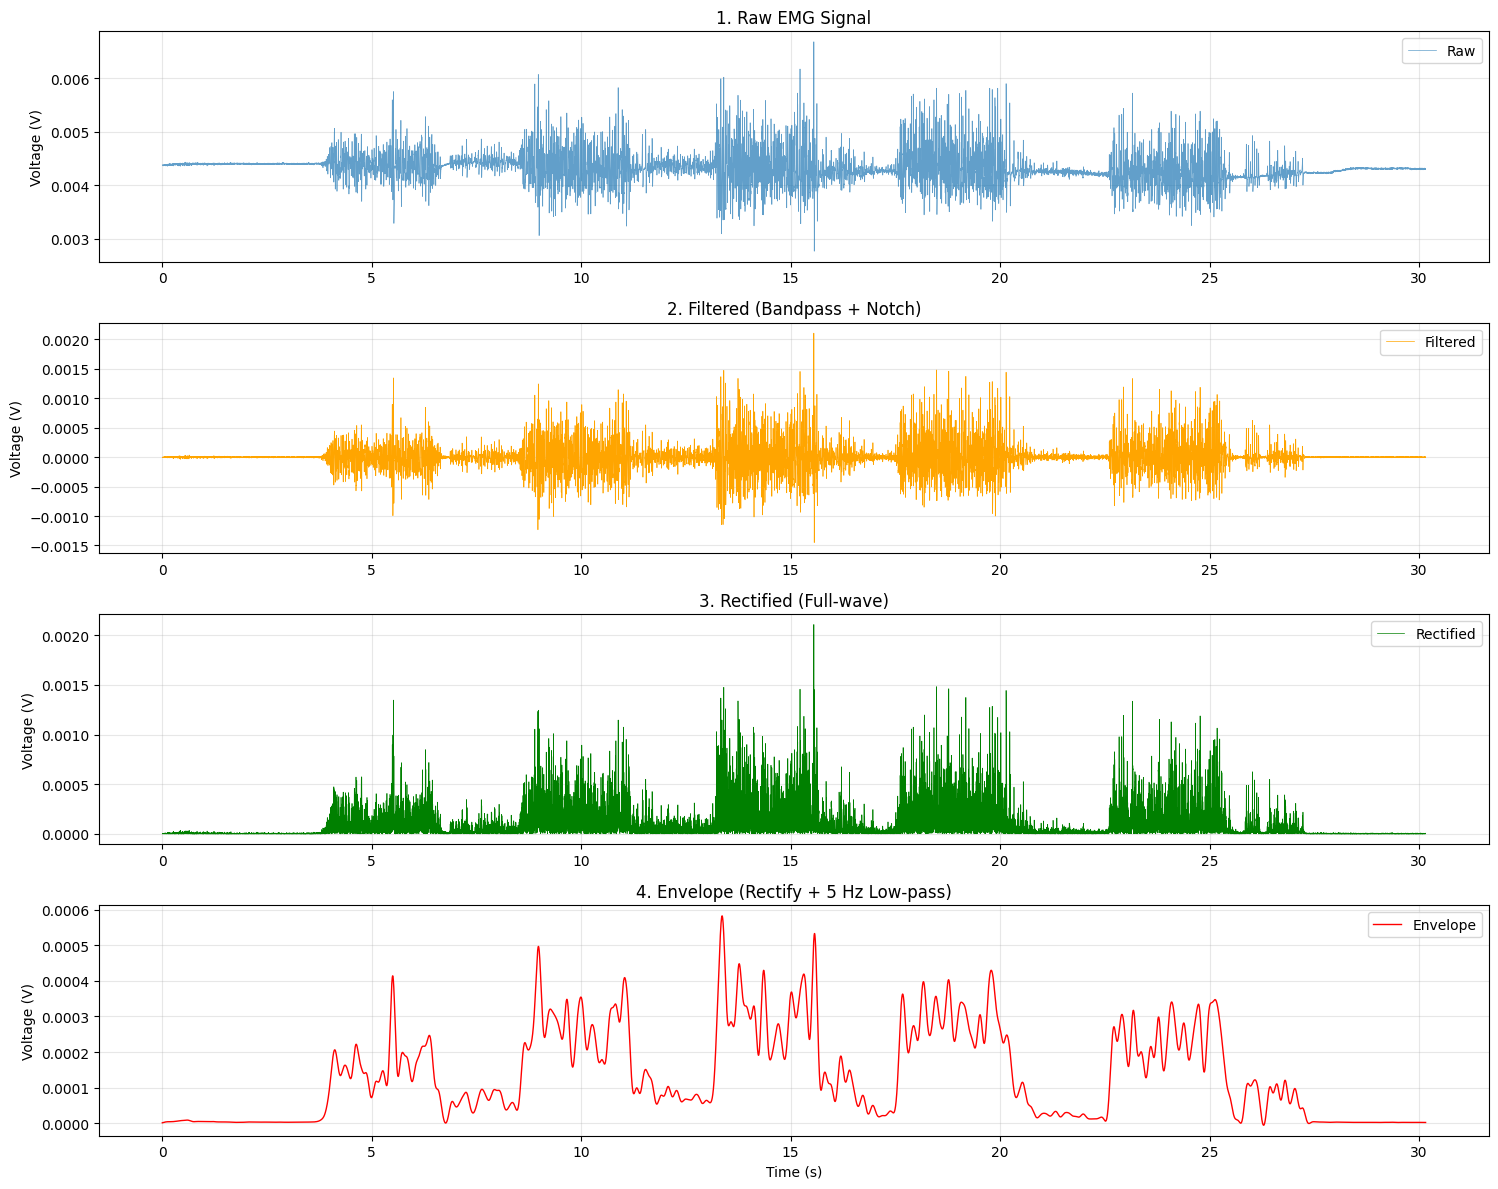

In [70]:
# Apply all processing steps
rectified_signal = process_rectified(filtered_signal)
envelope_signal = process_envelope(filtered_signal, fs)

# Plot all processing stages
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Raw
axes[0].plot(timestamps, raw_signal, linewidth=0.5, alpha=0.7, label='Raw')
axes[0].set_ylabel('Voltage (V)')
axes[0].set_title('1. Raw EMG Signal')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Filtered
axes[1].plot(timestamps, filtered_signal, linewidth=0.5, color='orange', label='Filtered')
axes[1].set_ylabel('Voltage (V)')
axes[1].set_title('2. Filtered (Bandpass + Notch)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Rectified
axes[2].plot(timestamps, rectified_signal, linewidth=0.5, color='green', label='Rectified')
axes[2].set_ylabel('Voltage (V)')
axes[2].set_title('3. Rectified (Full-wave)')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

# Envelope
axes[3].plot(timestamps, envelope_signal, linewidth=1, color='red', label='Envelope')
axes[3].set_xlabel('Time (s)')
axes[3].set_ylabel('Voltage (V)')
axes[3].set_title('4. Envelope (Rectify + 5 Hz Low-pass)')
axes[3].grid(True, alpha=0.3)
axes[3].legend()

plt.tight_layout()
plt.show()

## Extract EMG Features (RMS, MAV)

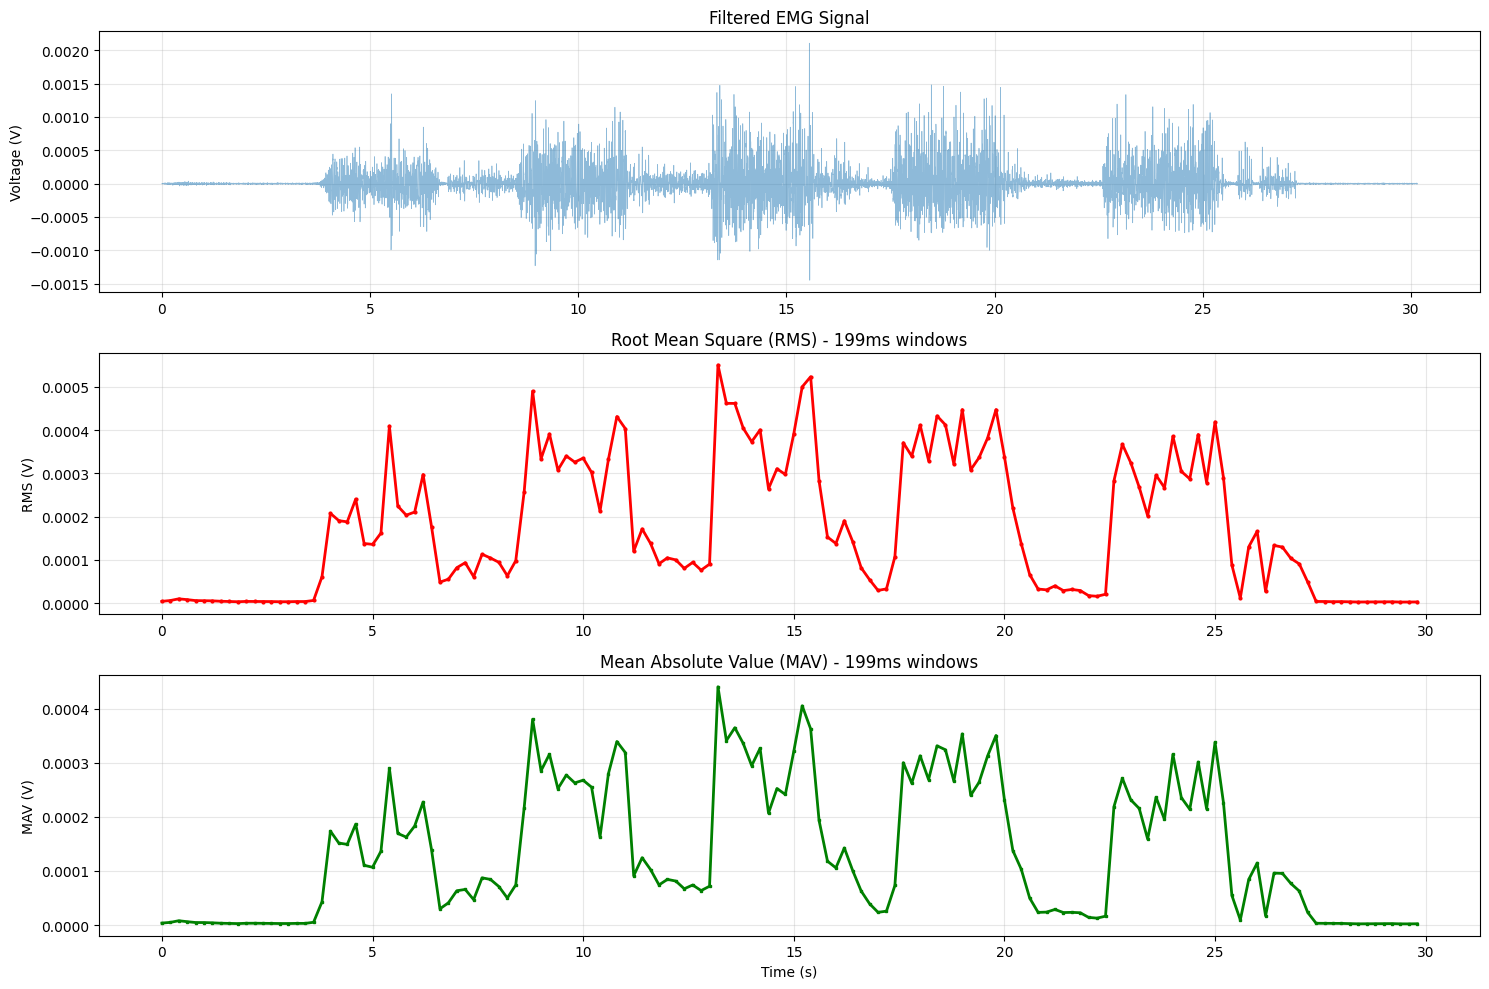

RMS: min=0.000003 V, max=0.000550 V, mean=0.000176 V
MAV: min=0.000002 V, max=0.000441 V, mean=0.000137 V


In [71]:
# Calculate RMS in windows
window_size = int((WINDOW_SIZE_MS / 1000) * fs)  # Convert ms to samples
n_windows = len(filtered_signal) // window_size
filtered_windows = filtered_signal[:n_windows * window_size].reshape(n_windows, window_size)

# Calculate RMS for each window
rms_values = rms(filtered_windows).flatten()
rms_times = np.arange(n_windows) * window_size / fs

# Calculate MAV for each window
mav_values = mav(filtered_windows).flatten()

# Plot RMS and MAV
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Filtered signal
axes[0].plot(timestamps, filtered_signal, linewidth=0.5, alpha=0.5)
axes[0].set_ylabel('Voltage (V)')
axes[0].set_title('Filtered EMG Signal')
axes[0].grid(True, alpha=0.3)

# RMS
axes[1].plot(rms_times, rms_values, linewidth=2, color='red', marker='o', markersize=2)
axes[1].set_ylabel('RMS (V)')
axes[1].set_title(f'Root Mean Square (RMS) - {int(window_size/fs*1000)}ms windows')
axes[1].grid(True, alpha=0.3)

# MAV
axes[2].plot(rms_times, mav_values, linewidth=2, color='green', marker='s', markersize=2)
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('MAV (V)')
axes[2].set_title(f'Mean Absolute Value (MAV) - {int(window_size/fs*1000)}ms windows')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"RMS: min={rms_values.min():.6f} V, max={rms_values.max():.6f} V, mean={rms_values.mean():.6f} V")
print(f"MAV: min={mav_values.min():.6f} V, max={mav_values.max():.6f} V, mean={mav_values.mean():.6f} V")

## FFT Analysis (Frequency Domain)

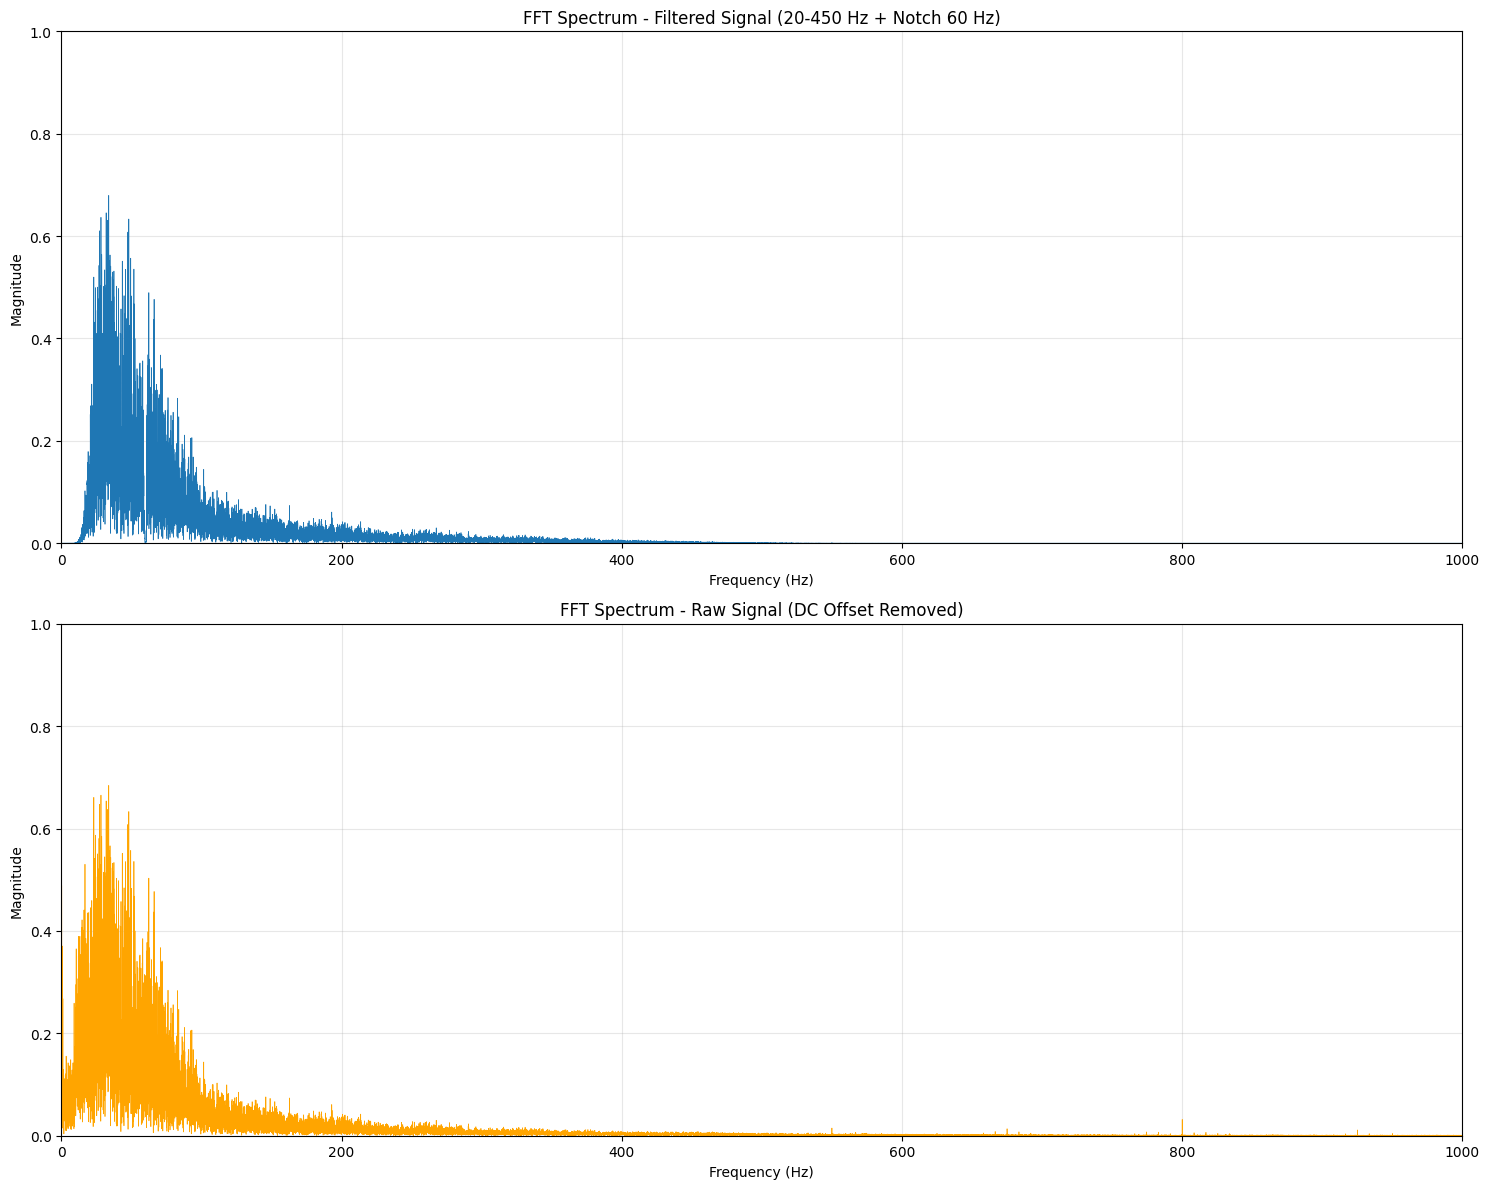

Top 5 dominant frequencies in filtered EMG range (20-450 Hz):
  1. 33.9 Hz - Magnitude: 0.68
  2. 32.0 Hz - Magnitude: 0.65
  3. 28.3 Hz - Magnitude: 0.64
  4. 48.2 Hz - Magnitude: 0.63
  5. 33.0 Hz - Magnitude: 0.63

Note: DC offset removed from raw signal for visualization
  Original DC component: 0.004323 V


In [72]:
# Analyze frequency content of the entire signal
fft_result = process_fft(filtered_signal).flatten()

# For raw signal, remove DC offset before FFT to see actual frequency content
emg_signal_no_dc = emg_signal - np.mean(emg_signal)  # Remove DC offset
fft_raw = process_fft(emg_signal_no_dc).flatten()

# Create frequency axis
freqs = np.fft.rfftfreq(len(filtered_signal), 1/fs)
freqs_raw = np.fft.rfftfreq(len(emg_signal), 1/fs)

# Plot FFT
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Filtered signal spectrum
axes[0].plot(freqs, fft_result, linewidth=0.5)
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Magnitude')
axes[0].set_title('FFT Spectrum - Filtered Signal (20-450 Hz + Notch 60 Hz)')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 1000])  # Focus on EMG range
axes[0].set_ylim([0, 1])

# Raw signal spectrum (DC removed)
axes[1].plot(freqs_raw, fft_raw, linewidth=0.5, color='orange')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude')
axes[1].set_title('FFT Spectrum - Raw Signal (DC Offset Removed)')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 1000])  # Focus on EMG range
axes[1].set_ylim([0, 1])


plt.tight_layout()
plt.show()

# Find dominant frequencies in EMG range
emg_mask = (freqs >= 20) & (freqs <= 450)
emg_freqs = freqs[emg_mask]
emg_fft = fft_result[emg_mask]
peak_indices = np.argsort(emg_fft)[-5:][::-1]

print("Top 5 dominant frequencies in filtered EMG range (20-450 Hz):")
for i, idx in enumerate(peak_indices):
    print(f"  {i+1}. {emg_freqs[idx]:.1f} Hz - Magnitude: {emg_fft[idx]:.2f}")

print(f"\nNote: DC offset removed from raw signal for visualization")
print(f"  Original DC component: {np.mean(emg_signal):.6f} V")

## Activation Timing Detection

First contraction detected: 3.80s to 5.60s
First contraction mean RMS: 0.000193 V
Threshold: 0.000096 V


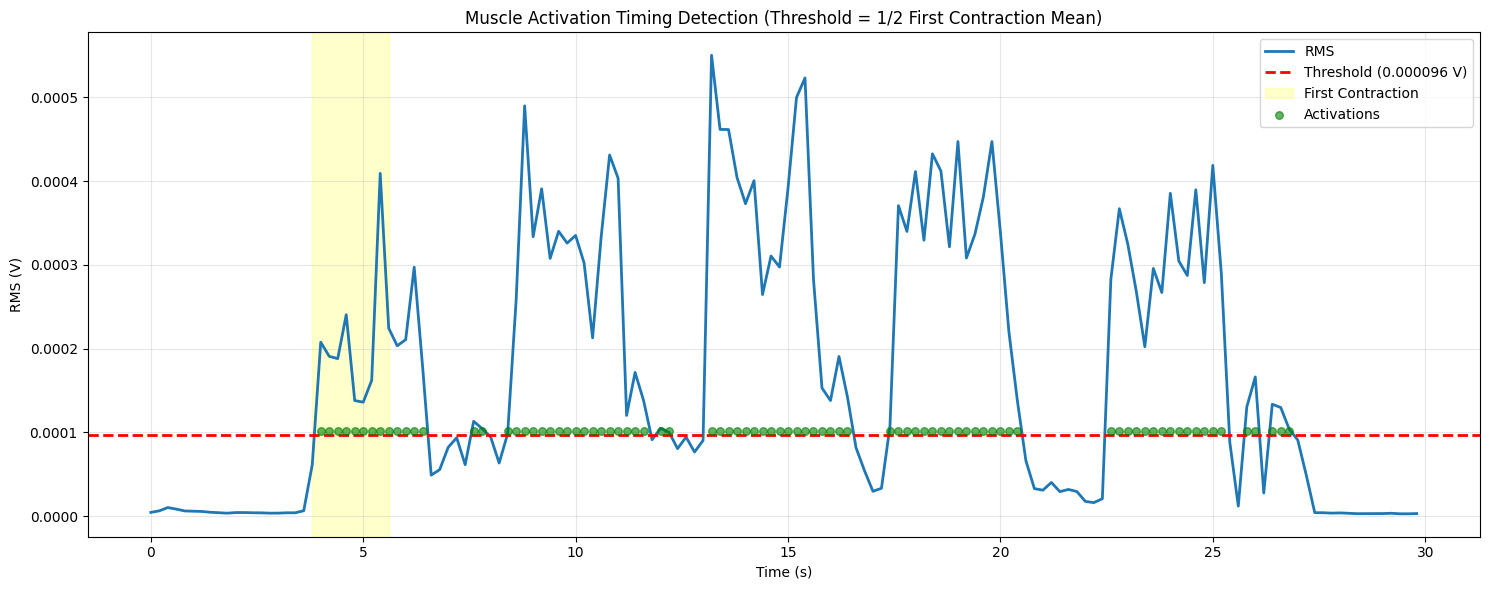

Activation threshold: 0.000096 V
Total activation time points: 86
Activation percentage: 57.3%


In [73]:
# Calculate RMS for activation timing
window_size = int((WINDOW_SIZE_MS / 1000) * fs)  # Convert ms to samples
n_windows = len(filtered_signal) // window_size
filtered_windows = filtered_signal[:n_windows * window_size].reshape(n_windows, window_size)
rms_for_timing = rms(filtered_windows).flatten()
rms_times = np.arange(n_windows) * window_size / fs

# Effective sampling frequency for RMS data
fs_rms = fs / window_size

# Detect contractions using rate-of-change method (from config)
rate_threshold = RATE_THRESHOLD
min_duration = MIN_CONTRACTION_DURATION
min_duration_samples = int(min_duration * fs_rms)

contractions = detect_contractions_rms_rate(
    rms_for_timing, 
    fs_rms, 
    rate_threshold=rate_threshold,
    min_duration_samples=min_duration_samples
)

# Use the first detected contraction to establish threshold
if len(contractions) > 0:
    start_t, end_t, peak = contractions[0]
    start_idx = int(start_t * fs_rms)
    end_idx = int(end_t * fs_rms)
    
    # Calculate threshold as 1/2 the mean of RMS values during first contraction
    first_contraction_mean = np.mean(rms_for_timing[start_idx:end_idx])
    threshold = first_contraction_mean / 2
    print(f"First contraction detected: {start_t:.2f}s to {end_t:.2f}s")
    print(f"First contraction mean RMS: {first_contraction_mean:.6f} V")
else:
    # Fallback: use baseline-based threshold if no contraction detected
    baseline_samples = int(len(rms_for_timing) * BASELINE_SAMPLES_PERCENT)
    baseline_rms = np.mean(rms_for_timing[:baseline_samples])
    threshold = baseline_rms * THRESHOLD_FACTOR
    start_idx, end_idx = None, None
    print("No contraction detected using rate-of-change method, using baseline threshold")

print(f"Threshold: {threshold:.6f} V")

# Detect activation times
activation_times = activation_timing_post(rms_for_timing, fs_rms, threshold)

# Plot activation timing
plt.figure(figsize=(15, 6))
plt.plot(rms_times, rms_for_timing, linewidth=2, label='RMS')
plt.axhline(y=threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.6f} V)')
if len(contractions) > 0:
    start_t, end_t, peak = contractions[0]
    # Highlight the first contraction region
    plt.axvspan(start_t, end_t, alpha=0.2, color='yellow', label='First Contraction')
plt.scatter(activation_times, np.ones_like(activation_times) * threshold * 1.05, 
           color='green', s=30, alpha=0.6, label='Activations', zorder=5)
plt.xlabel('Time (s)')
plt.ylabel('RMS (V)')
plt.title('Muscle Activation Timing Detection (Threshold = 1/2 First Contraction Mean)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Activation threshold: {threshold:.6f} V")
print(f"Total activation time points: {len(activation_times)}")
if len(rms_for_timing) > 0:
    print(f"Activation percentage: {len(activation_times) / len(rms_for_timing) * 100:.1f}%")

## Contraction Detection (Rate-of-Change Method)

Detected 5 contractions:
  Contraction 1: 3.80s - 5.60s (duration: 1.80s, peak RMS: 0.000409V)
  Contraction 2: 8.60s - 11.00s (duration: 2.40s, peak RMS: 0.000490V)
  Contraction 3: 13.00s - 15.40s (duration: 2.40s, peak RMS: 0.000550V)
  Contraction 4: 17.40s - 20.00s (duration: 2.60s, peak RMS: 0.000447V)
  Contraction 5: 22.40s - 25.20s (duration: 2.80s, peak RMS: 0.000419V)


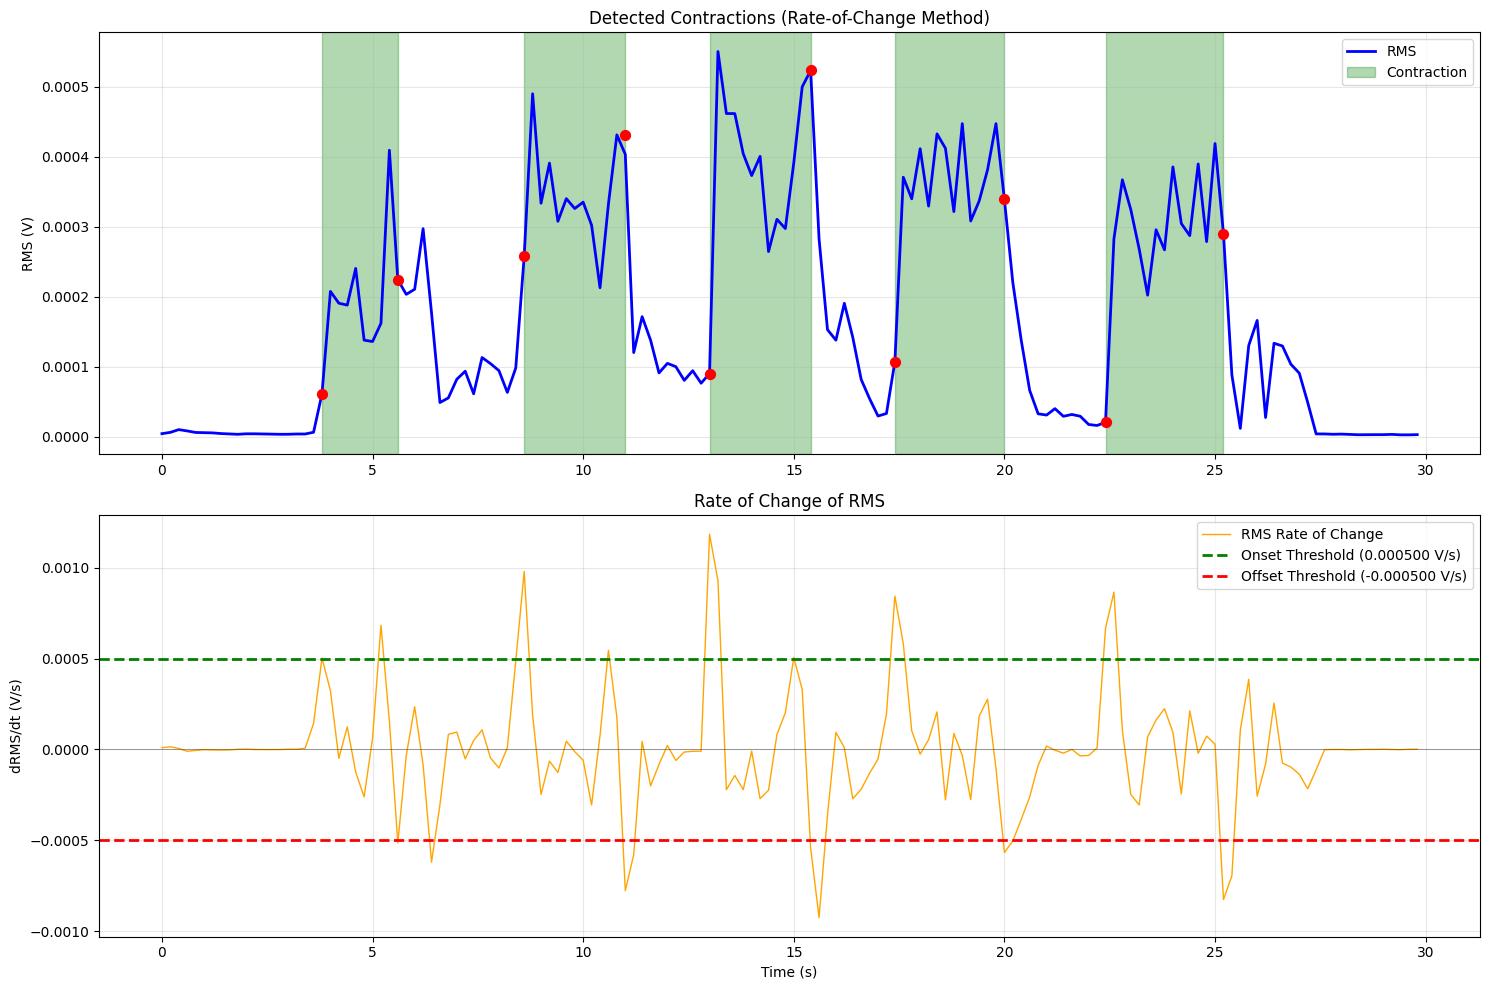

In [74]:
# Detect contractions using rate of change in RMS
window_size = int((WINDOW_SIZE_MS / 1000) * fs)  # Convert ms to samples
n_windows = len(filtered_signal) // window_size
filtered_windows = filtered_signal[:n_windows * window_size].reshape(n_windows, window_size)
rms_for_detection = rms(filtered_windows).flatten()
rms_times = np.arange(n_windows) * window_size / fs

# Effective sampling frequency for RMS data
fs_rms = fs / window_size

# Detect contractions (using config parameters)
rate_threshold = RATE_THRESHOLD
min_duration = MIN_CONTRACTION_DURATION
min_duration_samples = int(min_duration * fs_rms)

contractions = detect_contractions_rms_rate(
    rms_for_detection, 
    fs_rms, 
    rate_threshold=rate_threshold,
    min_duration_samples=min_duration_samples
)

print(f"Detected {len(contractions)} contractions:")
for i, (start_t, end_t, peak) in enumerate(contractions):
    duration = end_t - start_t
    print(f"  Contraction {i+1}: {start_t:.2f}s - {end_t:.2f}s (duration: {duration:.2f}s, peak RMS: {peak:.6f}V)")

# Visualize detected contractions
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# RMS with detected contractions
axes[0].plot(rms_times, rms_for_detection, linewidth=2, label='RMS', color='blue')
for i, (start_t, end_t, peak) in enumerate(contractions):
    axes[0].axvspan(start_t, end_t, alpha=0.3, color='green', label='Contraction' if i == 0 else '')
    axes[0].scatter([start_t, end_t], [rms_for_detection[int(start_t*fs_rms)], rms_for_detection[min(int(end_t*fs_rms), len(rms_for_detection)-1)]], 
                   color='red', s=50, zorder=5)
axes[0].set_ylabel('RMS (V)')
axes[0].set_title('Detected Contractions (Rate-of-Change Method)')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Rate of change of RMS
drms_dt = np.gradient(rms_for_detection, 1/fs_rms)
axes[1].plot(rms_times, drms_dt, linewidth=1, color='orange', label='RMS Rate of Change')
axes[1].axhline(y=rate_threshold, color='g', linestyle='--', linewidth=2, label=f'Onset Threshold ({rate_threshold:.6f} V/s)')
axes[1].axhline(y=-rate_threshold, color='r', linestyle='--', linewidth=2, label=f'Offset Threshold ({-rate_threshold:.6f} V/s)')
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.5)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('dRMS/dt (V/s)')
axes[1].set_title('Rate of Change of RMS')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

## Fatigue Analysis (Time to Fatigue)

Fatigue Analysis Results:
  RMS-based fatigue onset: [0.00000000e+00 4.99991709e-04 9.99983418e-04 ... 3.00520017e+01
 3.00525017e+01 3.00530017e+01]
  Median frequency-based fatigue onset: [ 0.06399894  0.08899852  0.11399811  0.1389977   0.18899687  0.21399645
  0.23899604  0.26399562  0.28899521  0.36399396  0.41399314  0.43899272
  0.56399065  0.58899023  0.61398982  0.6389894   0.76398733  0.78898692
  0.8139865   0.91398484  0.93898443  0.96398402  0.9889836   1.01398319
  1.13898111  1.1639807   1.28897863  1.31397821  1.36397738  1.38897697
  1.56397407  1.58897365  1.61397324  1.66397241  1.73897116  1.78897034
  1.81396992  1.83896951  1.86396909  1.88896868  1.91396826  1.93896785
  2.06396578  2.08896536  2.21396329  2.23896287  2.28896204  2.31396163
  2.33896122  2.3639608   2.46395914  2.48895873  2.58895707  2.61395666
  2.66395583  2.73895458  2.78895375  2.81395334  2.8889521   2.91395168
  2.93895127  2.96395085  2.98895044  3.06394919  3.08894878  3.11394836
  3.213

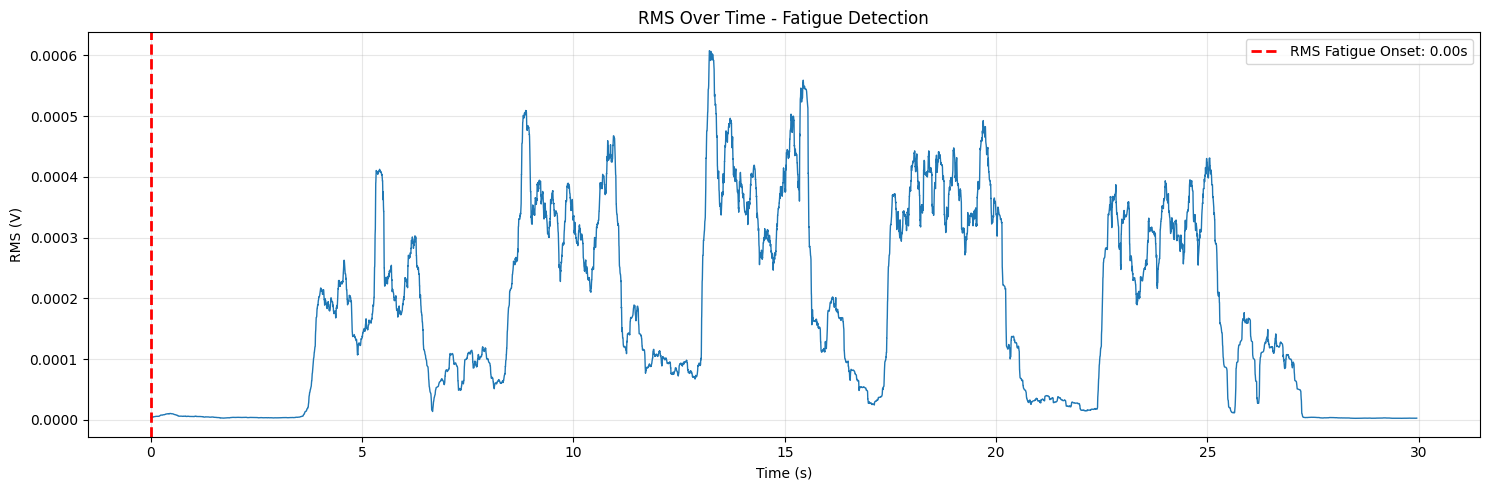

In [75]:
# Apply notch filter for fatigue analysis
notch_filtered = notch(filtered_signal, freq=NOTCH_FREQ, fs=fs, quality=NOTCH_QUALITY)

# Calculate time to fatigue (using config parameters)
rms_threshold = RMS_FATIGUE_THRESHOLD
mf_threshold = MF_FATIGUE_THRESHOLD

try:
    time_to_rms_fatigue, time_to_mf_fatigue = time_to_fatigue_post(
        filtered_signal, 
        notch_filtered, 
        fs, 
        rms_threshold, 
        mf_threshold
    )
    
    print("Fatigue Analysis Results:")
    print(f"  RMS-based fatigue onset: {time_to_rms_fatigue if time_to_rms_fatigue is not None else 'Not detected'}")
    print(f"  Median frequency-based fatigue onset: {time_to_mf_fatigue if time_to_mf_fatigue is not None else 'Not detected'}")
    
    # Visualize RMS over time
    window_size = int((WINDOW_SIZE_MS / 1000) * fs)  # Convert ms to samples
    rms_sliding = np.sqrt(np.convolve(filtered_signal**2, np.ones(window_size)/window_size, mode='valid'))
    t_rms = np.arange(len(rms_sliding)) / fs
    
    plt.figure(figsize=(15, 5))
    plt.plot(t_rms, rms_sliding, linewidth=1)
    if time_to_rms_fatigue is not None and hasattr(time_to_rms_fatigue, '__len__'):
        plt.axvline(x=time_to_rms_fatigue[0], color='r', linestyle='--', 
                   linewidth=2, label=f'RMS Fatigue Onset: {time_to_rms_fatigue[0]:.2f}s')
    elif time_to_rms_fatigue is not None:
        plt.axvline(x=time_to_rms_fatigue, color='r', linestyle='--', 
                   linewidth=2, label=f'RMS Fatigue Onset: {time_to_rms_fatigue:.2f}s')
    plt.xlabel('Time (s)')
    plt.ylabel('RMS (V)')
    plt.title('RMS Over Time - Fatigue Detection')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Fatigue analysis error: {e}")
    print("Note: This analysis works best with sustained contraction data")

## Summary: EMG Processing Pipeline Results

This notebook demonstrates the complete EMG processing pipeline on real BICEP EMG data:

1. **Data Loading**: Single-channel BICEP EMG recording from RawEMG.csv
2. **Signal Characteristics**: 
   - Sampling rate: ~2000 Hz
   - Duration: ~30 seconds
   - Voltage range: 0.003-0.007 V
3. **Filtering**: Bandpass (20-450 Hz) + 60 Hz notch filter
4. **Rectification**: Full-wave rectification for amplitude extraction
5. **Envelope Detection**: Smooth amplitude tracking with 5 Hz low-pass filtering
6. **Feature Extraction**:
   - RMS (Root Mean Square) - muscle activity intensity
   - MAV (Mean Absolute Value) - average muscle activation
7. **Frequency Analysis**: FFT transform shows dominant EMG frequency components
8. **Activation Timing**: Identifies when muscle activation exceeds baseline threshold
9. **Fatigue Analysis**: Detects fatigue onset based on RMS and median frequency changes

All processing functions are self-contained and use proper filter normalization!